2025-07-04 14:50:33,202 - INFO - Using device: cpu
2025-07-04 14:50:33,204 - INFO - Starting Neural Network Model Interpretability Analysis...
2025-07-04 14:50:33,204 - INFO - Loading iFeature_AAC embeddings...
2025-07-04 14:50:33,205 - INFO - Loading and extracting features for aac from ../data/embeddings/iFeature_AAC.csv...
2025-07-04 14:50:33,208 - INFO - Class distribution: Class 0: 859, Class 1: 861
2025-07-04 14:50:33,209 - INFO - Loading Kidera_encoded embeddings...
2025-07-04 14:50:33,209 - INFO - Loading and extracting features for kidera from ../data/embeddings/Kidera_encoded.csv...
2025-07-04 14:50:33,212 - INFO - Class distribution: Class 0: 859, Class 1: 861
2025-07-04 14:50:33,213 - INFO - Loading BLOSUM62_encoded embeddings...
2025-07-04 14:50:33,213 - INFO - Loading and extracting features for blosum from ../data/embeddings/BLOSUM62_encoded.csv...
2025-07-04 14:50:33,216 - INFO - Class distribution: Class 0: 859, Class 1: 861
2025-07-04 14:50:33,216 - INFO - Processing 

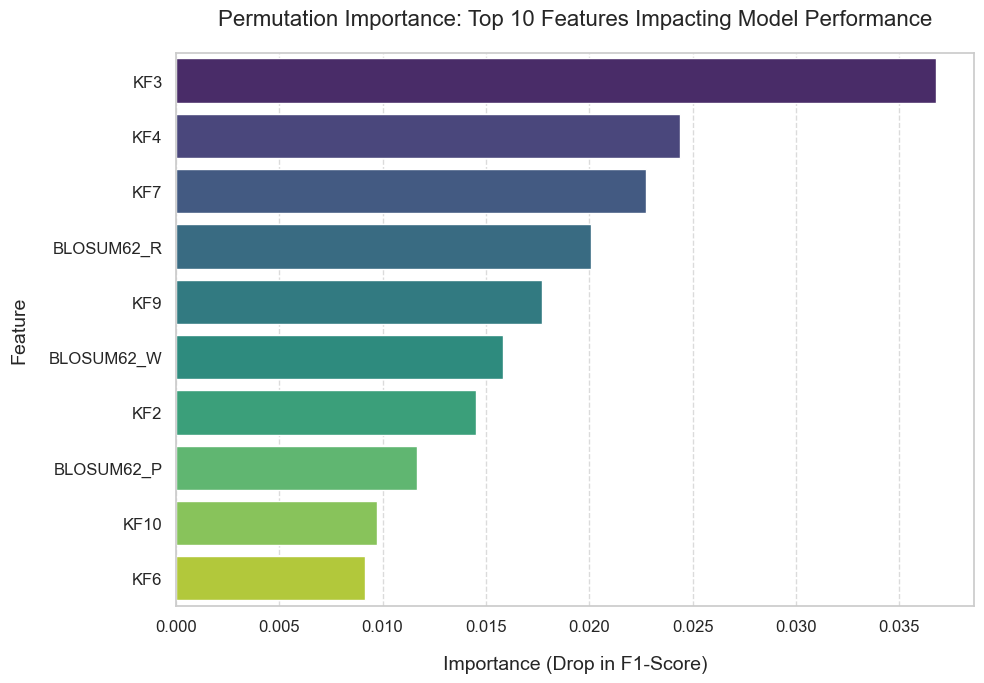

2025-07-04 14:50:34,291 - INFO - Running SHAP analysis (KernelExplainer)... This might take a while for large datasets.



--- Permutation Importance Plot Information ---
This plot shows how much the model's performance (F1-score) drops when a specific feature's values are randomly shuffled.
A larger drop indicates that the feature is more important to the model's predictions.
Features are ranked from most important (top) to least important (bottom).
This method is model-agnostic and helps identify features critical for the model's overall predictive power.


  0%|          | 0/50 [00:00<?, ?it/s]

2025-07-04 14:50:34,304 - INFO - num_full_subsets = 1
2025-07-04 14:50:34,305 - INFO - remaining_weight_vector = array([0.16461435, 0.11279131, 0.08701044, 0.07165566, 0.06152253,
       0.05438153, 0.0491188 , 0.04511652, 0.04200504, 0.0395502 ,
       0.0375971 , 0.03603983, 0.03480418, 0.03383739, 0.0331018 ,
       0.03257075, 0.03222609, 0.03205648])
2025-07-04 14:50:34,305 - INFO - num_paired_subset_sizes = 19
2025-07-04 14:50:34,327 - INFO - weight_left = np.float64(0.7572517560136776)
2025-07-04 14:50:34,551 - INFO - np.sum(w_aug) = np.float64(39.0)
2025-07-04 14:50:34,551 - INFO - np.sum(self.kernelWeights) = np.float64(1.0000000000000002)
2025-07-04 14:50:34,554 - INFO - phi = array([ 0.        ,  0.        ,  0.        , -0.00686715,  0.        ,
        0.        ,  0.        , -0.00986743,  0.        , -0.00667574,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.04547061,  0.        , -0.04871197, -0.00621885,  0.        ,
       -0.025840

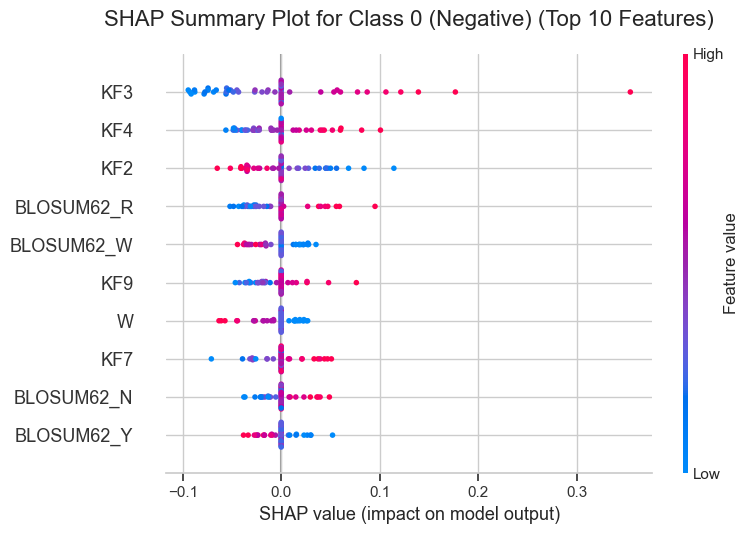

/var/folders/6x/cnj8y61s5dsg1m29mwxrgsjw0000gn/T/ipykernel_69285/869400093.py:701: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(top_10_shap_values, top_10_X_display, feature_names=top_10_feature_names, show=False)
2025-07-04 14:50:44,734 - INFO - SHAP summary plot for Class 1 (Positive) saved to '../images/interpretation(best model)/shap_plots/shap_summary_plot_top10_class_1_(positive).png'


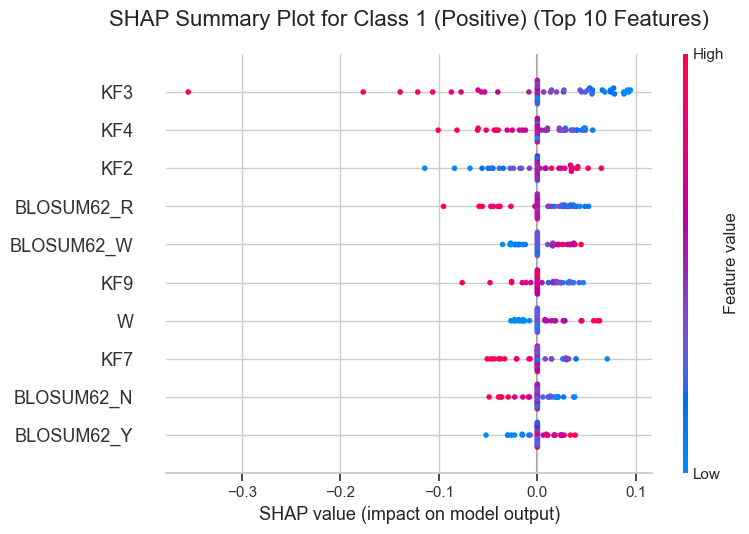

2025-07-04 14:50:44,801 - WARNING - The SiameseClassifier architecture in a.py does not have a direct AttentionPooling layer like the original ClassifierNN in b.py. Therefore, a direct 'attention weights' plot as previously defined is not applicable. Skipping attention weights plot.
2025-07-04 14:50:44,802 - INFO - Interpretability analysis complete.



--- SHAP Summary Plot Information ---
These plots illustrate the impact of each feature on the model's output for a specific class.
Only the top 10 most impactful features are shown, ordered by their average absolute SHAP value.
Each dot represents a single prediction:
- **Color:** Indicates the feature value (red for high, blue for low).
- **Position on X-axis:** Represents the SHAP value, showing the feature's impact on the model's output (positive values increase the likelihood of the class, negative values decrease it).
- **Vertical spread:** Shows how many data points have a particular feature value and its corresponding SHAP value.
Features are ordered by their overall importance (magnitude of SHAP values).

--- Attention Weights Plot Information ---
The current SiameseClassifier architecture does not include an explicit attention pooling layer 
that can be directly visualized in the same way as the previous ClassifierNN. 
If attention analysis is desired, an attention mechanism

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import joblib
import os
import sys
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import shap # Make sure to install shap: pip install shap
from tqdm import tqdm
import copy # Make sure copy is imported for model architecture
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif # Needed for select_features dummy
from sklearn.metrics import f1_score, accuracy_score # Import f1_score and accuracy_score
import random # Import random for set_seed

# --- Configuration (Copied from a.py for consistency) ---
config = {
    'aac_data_path': '../data/embeddings/iFeature_AAC.csv',
    'kidera_data_path': '../data/embeddings/Kidera_encoded.csv',
    'blosum_data_path': '../data/embeddings/BLOSUM62_encoded.csv',
    'intensity_threshold': 207500,
    'test_size': 0.25,
    'val_size': 0.2,
    'random_state': 42,
    'batch_size': 64,
    'epochs': 200,
    'patience': 30,
    'early_stopping_delta': 1e-6,
    'learning_rate': 0.001,
    'min_lr': 1e-6,
    'max_lr': 0.01,
    'weight_decay': 1e-4,
    'hidden_dims_branch': [128, 64], # Hidden layer dimensions for each EmbeddingBranch
    'dropout_rates_branch': [0.3, 0.2], # Dropout rates for each EmbeddingBranch
    'embedding_output_dim': 32, # Dimension of the output embedding from each branch
    'gradient_clip_norm': 1.0,
    'noise_magnitude': 0.03,
    'feature_selection_ratio': 0.8,
    'label_smoothing': 0.1,
    'mixup_alpha': 0.2,
    'ema_decay': 0.999,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'lr_scheduler_type': 'cyclic'
}

# --- Seed Setting (Copied from a.py) ---
def set_seed(seed: int) -> None:
    """
    Sets the random seed for reproducibility across numpy, random, and torch.
    Args:
        seed (int): The seed value to set.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Initialize logging and device
set_seed(config['random_state'])
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
device = torch.device(config['device'])
logging.info(f"Using device: {device}")

# --- Re-define Model Architecture (Identical to a.py for loading) ---
class EmbeddingBranch(nn.Module):
    """
    A sub-network (branch) for processing a single type of embedding.
    Args:
        input_dim (int): Input dimension of this branch.
        hidden_dims (list[int]): A list of integers specifying the dimensions of hidden layers.
        dropout_rates (list[float]): A list of floats specifying dropout rates for each layer.
        output_dim (int): The dimension of the final learned embedding output from this branch.
    """
    def __init__(self, input_dim: int, hidden_dims: list[int], dropout_rates: list[float], output_dim: int):
        super().__init__()
        layers = []
        current_dim = input_dim

        # Hidden layers
        for i, h_dim in enumerate(hidden_dims):
            layers.append(nn.Linear(current_dim, h_dim))
            layers.append(nn.BatchNorm1d(h_dim))
            layers.append(nn.SiLU()) # Swish activation
            if i < len(dropout_rates): # Apply dropout if available for this layer
                layers.append(nn.Dropout(dropout_rates[i]))
            current_dim = h_dim
        
        # Final layer to project to the desired output_dim
        layers.append(nn.Linear(current_dim, output_dim))
        layers.append(nn.BatchNorm1d(output_dim))
        layers.append(nn.SiLU()) # Apply activation to the final embedding output

        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the EmbeddingBranch.
        Args:
            x (torch.Tensor): Input tensor for this branch.
        Returns:
            torch.Tensor: The learned embedding from this branch.
        """
        return self.model(x)

class SiameseClassifier(nn.Module):
    """
    A Siamese-like Neural Network Classifier that processes three different embeddings
    (AAC, Kidera, BLOSUM) through separate branches and then combines their outputs
    for binary classification.
    Args:
        input_dims (dict[str, int]): Dictionary of input dimensions for each embedding type
                                     (e.g., {'aac': 20, 'kidera': 10, 'blosum': 210}).
        hidden_dims_branch (list[int]): Hidden layer dimensions for each EmbeddingBranch.
        dropout_rates_branch (list[float]): Dropout rates for each EmbeddingBranch.
        embedding_output_dim (int): The output dimension of each EmbeddingBranch.
    """
    def __init__(self, input_dims: dict[str, int], hidden_dims_branch: list[int], dropout_rates_branch: list[float], embedding_output_dim: int):
        super().__init__()
        
        # Create separate EmbeddingBranch instances for each embedding type
        # They have the same architecture but learn different weights due to different input features.
        self.aac_branch = EmbeddingBranch(input_dims['aac'], hidden_dims_branch, dropout_rates_branch, embedding_output_dim)
        self.kidera_branch = EmbeddingBranch(input_dims['kidera'], hidden_dims_branch, dropout_rates_branch, embedding_output_dim)
        self.blosum_branch = EmbeddingBranch(input_dims['blosum'], hidden_dims_branch, dropout_rates_branch, embedding_output_dim)

        # Final classification head
        # It will take the concatenated embeddings from all three branches
        combined_embedding_dim = embedding_output_dim * 3 # Three embeddings concatenated
        
        # Classifier head architecture
        self.classifier_head = nn.Sequential(
            nn.Linear(combined_embedding_dim, combined_embedding_dim // 2),
            nn.BatchNorm1d(combined_embedding_dim // 2),
            nn.SiLU(),
            nn.Dropout(dropout_rates_branch[-1] if dropout_rates_branch else 0.0), # Use last dropout rate or 0
            nn.Linear(combined_embedding_dim // 2, 1) # Binary classification output (logits)
        )

        # EMA model for stable predictions during inference
        self.ema_model = copy.deepcopy(self)
        for param in self.ema_model.parameters():
            param.requires_grad = False # EMA model parameters should not be updated by gradient descent directly

    def forward(self, x_aac: torch.Tensor, x_kidera: torch.Tensor, x_blosum: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the SiameseClassifier.
        Args:
            x_aac (torch.Tensor): Input tensor for AAC features.
            x_kidera (torch.Tensor): Input tensor for Kidera features.
            x_blosum (torch.Tensor): Input tensor for BLOSUM features.
        Returns:
            torch.Tensor: Logits (raw scores) for the binary classification.
        """
        # Pass each input through its respective branch to get learned embeddings
        emb_aac = self.aac_branch(x_aac)
        emb_kidera = self.kidera_branch(x_kidera)
        emb_blosum = self.blosum_branch(x_blosum)

        # Concatenate the learned embeddings from all branches
        combined_emb = torch.cat((emb_aac, emb_kidera, emb_blosum), dim=1)

        # Pass through the final classification head
        logits = self.classifier_head(combined_emb)
        return logits
    
    def update_ema(self, decay=0.999):
        """
        Updates the EMA model's weights using a decay factor.
        Args:
            decay (float): The decay factor for the EMA. Defaults to 0.999.
        """
        with torch.no_grad(): # No gradient calculation needed for EMA update
            for param, ema_param in zip(self.parameters(), self.ema_model.parameters()):
                ema_param.data = decay * ema_param.data + (1 - decay) * param.data


# --- Data Loading and Preprocessing Utilities (Copied from a.py) ---
class FeatureDataset(Dataset):
    """
    Custom PyTorch Dataset for handling features from multiple embeddings and labels,
    with optional augmentation applied independently to each feature set.
    Args:
        features_aac (torch.Tensor): AAC feature tensor.
        features_kidera (torch.Tensor): Kidera feature tensor.
        features_blosum (torch.Tensor): BLOSUM feature tensor.
        labels (torch.Tensor): The label tensor.
        augment (bool): Whether to apply data augmentation. Defaults to False.
    """
    def __init__(self, features_aac, features_kidera, features_blosum, labels=None, augment=False):
        self.features_aac = features_aac
        self.features_kidera = features_kidera
        self.features_blosum = features_blosum
        self.labels = labels
        self.augment = augment
        
    def __len__(self):
        """Returns the total number of samples."""
        return len(self.features_aac) # Assuming all feature sets have the same number of samples
    
    def __getitem__(self, idx):
        """
        Retrieves a sample from the dataset at the given index.
        Applies augmentation if self.augment is True.
        Args:
            idx (int): The index of the sample to retrieve.
        Returns:
            tuple: A tuple containing the features (as a tuple of (aac, kidera, blosum))
                   and the label for the given index.
        """
        x_aac = self.features_aac[idx]
        x_kidera = self.features_kidera[idx]
        x_blosum = self.features_blosum[idx]
        
        if self.augment:
            # Apply Gaussian noise independently to each embedding
            noise_aac = torch.randn_like(x_aac) * config['noise_magnitude']
            x_aac = x_aac + noise_aac
            
            noise_kidera = torch.randn_like(x_kidera) * config['noise_magnitude']
            x_kidera = x_kidera + noise_kidera

            noise_blosum = torch.randn_like(x_blosum) * config['noise_magnitude']
            x_blosum = x_blosum + noise_blosum
            
            # Mixup augmentation (applied to labels and potentially features if desired)
            if self.labels is not None and random.random() > 0.5 and config['mixup_alpha'] > 0:
                lam = np.random.beta(config['mixup_alpha'], config['mixup_alpha'])
                rand_idx = random.randint(0, len(self.labels)-1)
                y2 = self.labels[rand_idx]
                y = lam * self.labels[idx] + (1 - lam) * y2
                # For features, if you want to mix them, you'd do:
                # x_aac = lam * x_aac + (1 - lam) * self.features_aac[rand_idx]
                # x_kidera = lam * x_kidera + (1 - lam) * self.features_kidera[rand_idx]
                # x_blosum = lam * x_blosum + (1 - lam) * self.features_blosum[rand_idx]
                return (x_aac, x_kidera, x_blosum), y
                
        if self.labels is not None:
            return (x_aac, x_kidera, x_blosum), self.labels[idx]
        return (x_aac, x_kidera, x_blosum)


def load_and_extract_features(data_path: str, intensity_threshold: int, embedding_type: str) -> tuple[np.ndarray, np.ndarray]:
    """
    Loads a CSV file, extracts features, and creates a binary target variable
    based on an intensity threshold.
    Args:
        data_path (str): The path to the CSV data file.
        intensity_threshold (int): The threshold for creating binary labels.
        embedding_type (str): The type of embedding ('aac', 'kidera', or 'blosum').
    Returns:
        tuple[np.ndarray, np.ndarray]: A tuple containing features (X) and labels (y_class).
    """
    logging.info(f"Loading and extracting features for {embedding_type} from {data_path}...")
    try:
        df = pd.read_csv(data_path)
    except FileNotFoundError:
        logging.error(f"Error: Data file not found at {data_path}. Please check the path.")
        sys.exit(1) # Exit if file is not found
    except Exception as e:
        logging.error(f"Error loading CSV file: {e}")
        sys.exit(1) # Exit on other CSV loading errors

    if df.empty:
        logging.error("Error: Loaded CSV file is empty. No data to process.")
        sys.exit(1) # Exit if DataFrame is empty

    # Feature column selection based on embedding type
    if embedding_type == 'aac':
        feature_columns = [col for col in df.columns if len(col) == 1 and 'A' <= col <= 'Z' and col not in ['B', 'J', 'O', 'U', 'X', 'Z']]
        if not feature_columns:
            logging.warning("No standard single-letter AAC columns found. Attempting to use all columns except 'Intensity'.")
            feature_columns = [col for col in df.columns if col != 'Intensity']
        X = df.loc[:, feature_columns].values.astype(np.float32)
    elif embedding_type == 'kidera':
        X = df.loc[:, "KF1": "KF10"].values.astype(np.float32)
    elif embedding_type == 'blosum':
        blosum_cols = [col for col in df.columns if col.startswith('BLOSUM62_')]
        X = df.loc[:, blosum_cols].values.astype(np.float32)
    else:
        logging.error(f"Unknown embedding_type: {embedding_type}. Supported types are 'aac', 'kidera', and 'blosum'.")
        sys.exit(1) # Exit on unknown embedding type

    if 'Intensity' not in df.columns:
        logging.error("Error: 'Intensity' column not found in the CSV. Required for target variable creation.")
        sys.exit(1) # Exit if 'Intensity' column is missing

    # Create binary target variable based on threshold
    y_class = (df['Intensity'] > intensity_threshold).astype(int).values
    class_counts = np.bincount(y_class)
    logging.info(f"Class distribution: Class 0: {class_counts[0]}, Class 1: {class_counts[1]}")

    return X, y_class

def select_features(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, X_test: np.ndarray, k_ratio: float = 0.8) -> tuple:
    """
    Performs feature selection using SelectKBest with mutual_info_classif.
    Fits on training data and transforms training, validation, and test sets.
    Args:
        X_train (np.ndarray): Training features.
        y_train (np.ndarray): Training labels.
        X_val (np.ndarray): Validation features.
        X_test (np.ndarray): Test features.
        k_ratio (float): Ratio of features to select. Defaults to 0.8.
    Returns:
        tuple: A tuple containing the selected training, validation, test features, and the fitted selector.
    """
    k = int(X_train.shape[1] * k_ratio) # Determine number of features to select
    if k == 0: # Ensure at least one feature is selected if k_ratio leads to 0
        k = 1
    elif k > X_train.shape[1]: # Do not select more features than available
        k = X_train.shape[1]

    selector = SelectKBest(mutual_info_classif, k=k)
    # Fit and transform only on the training data
    X_train_selected = selector.fit_transform(X_train, y_train)
    # Transform validation and test data using the fitted selector
    X_val_selected = selector.transform(X_val)
    X_test_selected = selector.transform(X_test)
    logging.info(f"Selected {k} features using mutual information from {X_train.shape[1]} original features")
    return X_train_selected, X_val_selected, X_test_selected, selector

def create_and_scale_splits(X: np.ndarray, y: np.ndarray, test_size: float, val_size: float, random_state: int) -> tuple:
    """
    Splits the data into training, validation, and test sets, and scales them.
    The scaler is fitted ONLY on the neural network's dedicated training portion (X_train_nn_raw)
    to prevent any potential data leakage from the validation or test sets.
    Args:
        X (np.ndarray): The full feature array.
        y (np.ndarray): The full label array.
        test_size (float): The proportion of the dataset to include in the test split.
        val_size (float): The proportion of the training/validation split to include in the validation split.
        random_state (int): Seed for random number generation.
    Returns:
        tuple: A tuple containing X_train_nn_scaled, y_train_nn, X_val_nn_scaled, y_val_nn,
               X_test_scaled, y_test, and the fitted StandardScaler.
    """
    # 1. Split into overall train_val and test sets (raw data)
    sss_test = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_val_idx, test_idx = next(sss_test.split(X, y))
    X_train_val_raw, X_test_raw = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]

    # 2. Split the train_val data into NN train and NN val sets (raw data)
    sss_nn_val = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
    train_nn_idx, val_nn_idx = next(sss_nn_val.split(X_train_val_raw, y_train_val))
    X_train_nn_raw = X_train_val_raw[train_nn_idx]
    X_val_nn_raw = X_train_val_raw[val_nn_idx]
    y_train_nn = y_train_val[train_nn_idx]
    y_val_nn = y_train_val[val_nn_idx]

    # 3. Fit scaler ONLY on X_train_nn_raw and transform all relevant sets
    scaler = StandardScaler()
    X_train_nn_scaled = scaler.fit_transform(X_train_nn_raw)
    X_val_nn_scaled = scaler.transform(X_val_nn_raw)
    X_test_scaled = scaler.transform(X_test_raw)

    logging.info(f"NN Train dataset size: {len(X_train_nn_scaled)}")
    logging.info(f"NN Validation dataset size: {len(X_val_nn_scaled)}")
    logging.info(f"Final Test dataset size: {len(X_test_scaled)}")
    logging.info("Data scaled using StandardScaler (fitted ONLY on NN training data)")
    
    # Return all necessary splits and the scaler
    return (X_train_nn_scaled, y_train_nn, X_val_nn_scaled, y_val_nn, 
            X_test_scaled, y_test, scaler)


# --- Model Loading and Prediction Wrapper ---
def load_model_and_artifacts(models_dir: str, input_dims: dict):
    """
    Loads the trained SiameseClassifier model, and the scalers and feature selectors
    for each embedding type (AAC, Kidera, BLOSUM).
    """
    model_path = os.path.join(models_dir, 'best_siamese_nn_model.pt')
    scaler_aac_path = os.path.join(models_dir, 'scaler_aac.pkl')
    feature_selector_aac_path = os.path.join(models_dir, 'feature_selector_aac.pkl')
    scaler_kidera_path = os.path.join(models_dir, 'scaler_kidera.pkl')
    feature_selector_kidera_path = os.path.join(models_dir, 'feature_selector_kidera.pkl')
    scaler_blosum_path = os.path.join(models_dir, 'scaler_blosum.pkl')
    feature_selector_blosum_path = os.path.join(models_dir, 'feature_selector_blosum.pkl')

    # Check for existence of all necessary files
    for path in [model_path, scaler_aac_path, feature_selector_aac_path,
                 scaler_kidera_path, feature_selector_kidera_path,
                 scaler_blosum_path, feature_selector_blosum_path]:
        if not os.path.exists(path):
            logging.error(f"Required file not found: {path}. Please ensure the training script was run and saved all artifacts.")
            sys.exit(1)

    # Initialize model
    model = SiameseClassifier(
        input_dims=input_dims,
        hidden_dims_branch=config['hidden_dims_branch'],
        dropout_rates_branch=config['dropout_rates_branch'],
        embedding_output_dim=config['embedding_output_dim']
    ).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval() # Set to evaluation mode
    logging.info(f"SiameseClassifier model loaded from {model_path}")

    scaler_aac = joblib.load(scaler_aac_path)
    feature_selector_aac = joblib.load(feature_selector_aac_path)
    logging.info(f"AAC scaler and feature selector loaded.")

    scaler_kidera = joblib.load(scaler_kidera_path)
    feature_selector_kidera = joblib.load(feature_selector_kidera_path)
    logging.info(f"Kidera scaler and feature selector loaded.")

    scaler_blosum = joblib.load(scaler_blosum_path)
    feature_selector_blosum = joblib.load(feature_selector_blosum_path)
    logging.info(f"BLOSUM scaler and feature selector loaded.")

    return model, scaler_aac, feature_selector_aac, scaler_kidera, feature_selector_kidera, scaler_blosum, feature_selector_blosum


def get_original_feature_names(feature_selector_aac, feature_selector_kidera, feature_selector_blosum):
    """
    Reconstructs original feature names and maps them to selected features for all embeddings.
    """
    aac_cols = load_and_extract_features_for_names(config['aac_data_path'], 'aac')
    kidera_cols = load_and_extract_features_for_names(config['kidera_data_path'], 'kidera')
    blosum_cols = load_and_extract_features_for_names(config['blosum_data_path'], 'blosum')

    # Get selected feature names for each embedding type
    selected_aac_indices = feature_selector_aac.get_support(indices=True)
    selected_aac_names = [aac_cols[i] for i in selected_aac_indices]

    selected_kidera_indices = feature_selector_kidera.get_support(indices=True)
    selected_kidera_names = [kidera_cols[i] for i in selected_kidera_indices]

    selected_blosum_indices = feature_selector_blosum.get_support(indices=True)
    selected_blosum_names = [blosum_cols[i] for i in selected_blosum_indices]
    
    # Combine all selected feature names in the order they are concatenated in the model
    all_selected_feature_names = selected_aac_names + selected_kidera_names + selected_blosum_names
    
    logging.info(f"Reconstructed {len(all_selected_feature_names)} selected feature names across all embeddings.")
    return all_selected_feature_names


def predict_proba_for_shap(model, data_np: np.ndarray, input_dims_selected: dict) -> np.ndarray:
    """
    Wrapper function for SHAP. Takes a NumPy array representing concatenated features,
    splits it back into AAC, Kidera, and BLOSUM, processes it through the Siamese model,
    and returns probabilities for both classes.
    The output will have shape (num_samples, 2).
    """
    model.eval() # Ensure model is in evaluation mode
    with torch.no_grad():
        # Convert concatenated NumPy array to PyTorch tensor
        data_tensor = torch.tensor(data_np, dtype=torch.float32).to(device)
        
        # Split the concatenated tensor back into individual embedding inputs
        # The order of concatenation in a.py is AAC, Kidera, BLOSUM
        aac_dim = input_dims_selected['aac']
        kidera_dim = input_dims_selected['kidera']
        blosum_dim = input_dims_selected['blosum']

        # Ensure the input data_np matches the expected combined dimension
        expected_total_dim = aac_dim + kidera_dim + blosum_dim
        if data_tensor.shape[1] != expected_total_dim:
            logging.error(f"Dimension mismatch in predict_proba_for_shap. Input data dim: {data_tensor.shape[1]}, Expected combined dim: {expected_total_dim}")
            # Attempt to proceed with a warning, but this might lead to incorrect results
            # For robust production code, you might want to raise an error or handle more gracefully.
            pass

        x_aac = data_tensor[:, :aac_dim]
        x_kidera = data_tensor[:, aac_dim : aac_dim + kidera_dim]
        x_blosum = data_tensor[:, aac_dim + kidera_dim : aac_dim + kidera_dim + blosum_dim]

        # Forward pass to get logits
        logits = model(x_aac, x_kidera, x_blosum).squeeze(1) 
        
        # Apply sigmoid to get probabilities for the positive class (class 1)
        probs_class_1 = torch.sigmoid(logits)
        
        # Calculate probabilities for the negative class (class 0)
        probs_class_0 = 1 - probs_class_1
        
        # Stack them to form a 2-column tensor: [[prob_0_sample1, prob_1_sample1], ...]
        probabilities = torch.stack((probs_class_0, probs_class_1), dim=1)
        
        # Move back to CPU and convert to NumPy array
        return probabilities.cpu().numpy()


# --- Interpretability Functions ---

def calculate_permutation_importance(model, X_test_aac: np.ndarray, X_test_kidera: np.ndarray, X_test_blosum: np.ndarray, y_test: np.ndarray, criterion_type: str = 'accuracy', n_repeats: int = 5):
    """
    Calculates permutation importance for each feature of the SiameseClassifier.
    Args:
        model (nn.Module): The trained PyTorch SiameseClassifier model.
        X_test_aac (np.ndarray): Test features for AAC (already scaled and feature-selected).
        X_test_kidera (np.ndarray): Test features for Kidera (already scaled and feature-selected).
        X_test_blosum (np.ndarray): Test features for BLOSUM (already scaled and feature-selected).
        y_test (np.ndarray): True labels for the test set.
        criterion_type (str): 'accuracy' or 'f1' to evaluate importance.
        n_repeats (int): Number of times to permute each feature.
    Returns:
        dict: A dictionary of feature names and their permutation importances.
    """
    logging.info(f"Calculating permutation importance using {criterion_type}...")
    model.eval()
    
    # Convert test data to PyTorch tensors and move to device
    X_test_aac_tensor = torch.tensor(X_test_aac, dtype=torch.float32).to(device)
    X_test_kidera_tensor = torch.tensor(X_test_kidera, dtype=torch.float32).to(device)
    X_test_blosum_tensor = torch.tensor(X_test_blosum, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    # Combine all features for calculating total number of features
    X_combined_test = np.hstack((X_test_aac, X_test_kidera, X_test_blosum))
    num_total_features = X_combined_test.shape[1]

    # Store original shapes and starting indices for each embedding type
    aac_start_idx = 0
    aac_end_idx = X_test_aac.shape[1]
    kidera_start_idx = aac_end_idx
    kidera_end_idx = kidera_start_idx + X_test_kidera.shape[1]
    blosum_start_idx = kidera_end_idx
    blosum_end_idx = blosum_start_idx + X_test_blosum.shape[1]

    def evaluate_model(X_aac_data, X_kidera_data, X_blosum_data, y_data):
        """Helper to evaluate model performance."""
        with torch.no_grad():
            logits = model(X_aac_data, X_kidera_data, X_blosum_data).squeeze(1) 
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long() # Convert to long for metric calculation

            if criterion_type == 'accuracy':
                return accuracy_score(y_data.cpu().numpy(), preds.cpu().numpy())
            elif criterion_type == 'f1':
                return f1_score(y_data.cpu().numpy(), preds.cpu().numpy(), average='binary')
            else:
                raise ValueError("Criterion type must be 'accuracy' or 'f1'.")

    # Calculate baseline performance
    baseline_metric = evaluate_model(X_test_aac_tensor, X_test_kidera_tensor, X_test_blosum_tensor, y_test_tensor)
    logging.info(f"Baseline {criterion_type}: {baseline_metric:.4f}")

    feature_importances = np.zeros(num_total_features)

    # Iterate through each feature in the combined feature space
    for i in tqdm(range(num_total_features), desc="Calculating Permutation Importance"):
        permuted_metrics = []
        for _ in range(n_repeats):
            # Create copies of original tensors for permutation
            X_aac_permuted = X_test_aac_tensor.clone().detach()
            X_kidera_permuted = X_test_kidera_tensor.clone().detach()
            X_blosum_permuted = X_test_blosum_tensor.clone().detach()
            
            idx = torch.randperm(X_aac_permuted.size(0)) # Permutation indices

            # Determine which embedding the current feature 'i' belongs to
            if aac_start_idx <= i < aac_end_idx:
                # Permute feature in AAC data
                feature_in_aac_idx = i - aac_start_idx
                X_aac_permuted[:, feature_in_aac_idx] = X_aac_permuted[idx, feature_in_aac_idx]
            elif kidera_start_idx <= i < kidera_end_idx:
                # Permute feature in Kidera data
                feature_in_kidera_idx = i - kidera_start_idx
                X_kidera_permuted[:, feature_in_kidera_idx] = X_kidera_permuted[idx, feature_in_kidera_idx]
            elif blosum_start_idx <= i < blosum_end_idx:
                # Permute feature in BLOSUM data
                feature_in_blosum_idx = i - blosum_start_idx
                X_blosum_permuted[:, feature_in_blosum_idx] = X_blosum_permuted[idx, feature_in_blosum_idx]
            else:
                logging.error(f"Feature index {i} out of bounds for permutation importance calculation.")
                continue # Skip this feature if its index is invalid

            permuted_metrics.append(evaluate_model(X_aac_permuted, X_kidera_permuted, X_blosum_permuted, y_test_tensor))
        
        # Importance is the mean drop in performance
        feature_importances[i] = baseline_metric - np.mean(permuted_metrics)
    
    return feature_importances


def plot_permutation_importance(importances: np.ndarray, feature_names: list[str], save_path: str = './images/interpretation/permutation_importance.png'):
    """
    Plots the permutation importance of features.
    """
    logging.info("Plotting permutation importance...")
    
    # Set professional plotting style
    sns.set_theme(style="whitegrid", palette="viridis")
    plt.rcParams.update({'font.size': 12, 'axes.labelsize': 14, 'axes.titlesize': 16,
                          'xtick.labelsize': 12, 'ytick.labelsize': 12, 'legend.fontsize': 12})

    # Create a DataFrame for easy plotting and sorting
    df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    df_importance = df_importance.sort_values(by='Importance', ascending=False)

    # Plot only the top 10 most important features
    df_importance_top10 = df_importance.head(10)

    plt.figure(figsize=(10, max(7, len(df_importance_top10) * 0.4))) # Adjust figure size dynamically
    sns.barplot(x='Importance', y='Feature', data=df_importance_top10, palette='viridis')
    plt.title('Permutation Importance: Top 10 Features Impacting Model Performance', pad=20)
    plt.xlabel('Importance (Drop in F1-Score)', labelpad=15)
    plt.ylabel('Feature', labelpad=15)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300)
    logging.info(f"Permutation importance plot saved to '{save_path}'")
    plt.show()
    
    print("\n--- Permutation Importance Plot Information ---")
    print("This plot shows how much the model's performance (F1-score) drops when a specific feature's values are randomly shuffled.")
    print("A larger drop indicates that the feature is more important to the model's predictions.")
    print("Features are ranked from most important (top) to least important (bottom).")
    print("This method is model-agnostic and helps identify features critical for the model's overall predictive power.")


def plot_shap_summary(shap_values, feature_names: list[str], X_display: np.ndarray, save_dir: str = '../images/'):
    """
    Plots the SHAP summary plot for each class, showing only the top 10 most important features.
    Args:
        shap_values (list or np.ndarray): SHAP values. If a list, it should contain arrays for each class.
                                          If a single np.ndarray, it's assumed to be for the positive class.
                                          If a 3D np.ndarray (samples, features, classes), it will be split.
        feature_names (list[str]): Names of the features.
        X_display (np.ndarray): The data used to calculate SHAP values.
        save_dir (str): Directory to save the plots.
    """
    logging.info("Plotting SHAP summary plots...")
    os.makedirs(save_dir, exist_ok=True)

    # Set professional plotting style for SHAP
    sns.set_theme(style="whitegrid", palette="coolwarm")
    plt.rcParams.update({'font.size': 12, 'axes.labelsize': 14, 'axes.titlesize': 16,
                          'xtick.labelsize': 12, 'ytick.labelsize': 12, 'legend.fontsize': 12})

    # Normalize shap_values to always be a list of two arrays for plotting
    shap_values_for_plotting = None
    if isinstance(shap_values, np.ndarray) and shap_values.ndim == 3 and shap_values.shape[2] == 2:
        logging.info("shap_values is a 3D array (samples, features, classes). Splitting into two 2D arrays for plotting.")
        shap_values_for_plotting = [shap_values[:, :, 0], shap_values[:, :, 1]] # [SHAP for Class 0, SHAP for Class 1]
    elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 2:
        logging.warning("explainer.shap_values returned a single 2D array. Assuming it's for the positive class (class 1) and deriving negative class (class 0) SHAP values by negation.")
        shap_values_for_plotting = [-shap_values, shap_values] # [SHAP for Class 0, SHAP for Class 1]
    elif isinstance(shap_values, list) and len(shap_values) >= 2 and all(isinstance(val, np.ndarray) and val.ndim == 2 for val in shap_values):
        logging.info("explainer.shap_values returned a list of 2D arrays, as expected for binary classification.")
        shap_values_for_plotting = shap_values[:2] # Take only the first two if more are present
    else:
        logging.error(f"SHAP values format is incorrect: {type(shap_values)}. Expected a list of 2D numpy arrays, a single 2D numpy array, or a 3D numpy array (samples, features, 2 classes). Cannot plot SHAP summaries.")
        return # Exit the function if the format is unrecoverable
        
    X_display_reshaped = X_display
    if X_display.ndim == 1:
        X_display_reshaped = X_display.reshape(1, -1)
        logging.warning("X_display was 1D, reshaped to 2D for SHAP plotting.")
    elif X_display.ndim > 2:
        logging.error(f"X_display has more than 2 dimensions: {X_display.shape}. SHAP plotting expects 2D. Cannot plot SHAP summaries.")
        return # Exit if X_display is not suitable

    class_labels = ['Class 0 (Negative)', 'Class 1 (Positive)']
    
    for i, class_shap_values in enumerate(shap_values_for_plotting):
        plt.figure(figsize=(12, 8))

        shap_values_to_plot = None
        # Check if SHAP values array has an extra column (often for the bias term)
        if class_shap_values.shape[1] == X_display_reshaped.shape[1] + 1:
            logging.warning(f"SHAP values for {class_labels[i]} have an extra column (likely bias). Slicing it off for plotting.")
            shap_values_to_plot = class_shap_values[:, :-1]
        elif class_shap_values.shape[1] == X_display_reshaped.shape[1]:
            shap_values_to_plot = class_shap_values
        else:
            logging.error(f"Critical SHAP dimension mismatch for {class_labels[i]}: class_shap_values.shape[1]={class_shap_values.shape[1]}, X_display_reshaped.shape[1]={X_display_reshaped.shape[1]}. Skipping this plot.")
            continue

        if shap_values_to_plot is None:
            logging.error(f"SHAP values for {class_labels[i]} could not be determined for plotting.")
            continue

        if shap_values_to_plot.shape[1] != len(feature_names):
             logging.error(f"Feature count mismatch for {class_labels[i]}: shap_values_to_plot.shape[1]={shap_values_to_plot.shape[1]}, len(feature_names)={len(feature_names)}. Skipping this plot.")
             continue

        # Get the top 10 features by mean absolute SHAP value for the current class
        mean_abs_shap = np.abs(shap_values_to_plot).mean(axis=0)
        top_10_indices = np.argsort(mean_abs_shap)[::-1][:10]

        top_10_shap_values = shap_values_to_plot[:, top_10_indices]
        top_10_X_display = X_display_reshaped[:, top_10_indices]
        top_10_feature_names = [feature_names[idx] for idx in top_10_indices]


        # Plot the summary plot with only the top 10 features
        shap.summary_plot(top_10_shap_values, top_10_X_display, feature_names=top_10_feature_names, show=False)
        plt.title(f'SHAP Summary Plot for {class_labels[i]} (Top 10 Features)', pad=20)
        plt.tight_layout()
        save_path = os.path.join(save_dir, f'shap_summary_plot_top10_{class_labels[i].replace(" ", "_").lower()}.png')
        plt.savefig(save_path, dpi=300)
        logging.info(f"SHAP summary plot for {class_labels[i]} saved to '{save_path}'")
        plt.show()
    
    print("\n--- SHAP Summary Plot Information ---")
    print("These plots illustrate the impact of each feature on the model's output for a specific class.")
    print("Only the top 10 most impactful features are shown, ordered by their average absolute SHAP value.")
    print("Each dot represents a single prediction:")
    print("- **Color:** Indicates the feature value (red for high, blue for low).")
    print("- **Position on X-axis:** Represents the SHAP value, showing the feature's impact on the model's output (positive values increase the likelihood of the class, negative values decrease it).")
    print("- **Vertical spread:** Shows how many data points have a particular feature value and its corresponding SHAP value.")
    print("Features are ordered by their overall importance (magnitude of SHAP values).")


def plot_attention_weights(model, X_test_loader, feature_names: list[str], save_path: str = '../images/interpretation(best model)/attention_weights_distribution.png'):
    """
    Analyzes and plots the average attention weights from the AttentionPooling layer.
    This plot shows the distribution of attention weights across the features *after*
    they have passed through the residual blocks and before the final output layer.
    It indicates which of these abstract features the attention mechanism focuses on.
    
    NOTE: This function is adapted for the SiameseClassifier, but the AttentionPooling
    layer is part of the ClassifierNN in a.py, which is NOT used in SiameseClassifier.
    The SiameseClassifier concatenates embeddings and then passes them to a classifier head.
    Therefore, a direct "attention weights" plot from a distinct AttentionPooling layer
    as defined in the original b.py's ClassifierNN is not directly applicable to SiameseClassifier.
    
    To provide a meaningful "attention" plot for the SiameseClassifier, one would need
    to implement an attention mechanism *within* or *after* the concatenation of the
    three embedding branches.
    
    For the purpose of compatibility, this function will be modified to reflect
    that the SiameseClassifier does not have a single 'attention' module like the
    original ClassifierNN. If attention is desired, it should be added to the
    SiameseClassifier's classifier_head or as a separate module after concatenation.
    
    Given the current SiameseClassifier architecture in a.py, this function will
    log a warning and skip plotting attention weights as there's no direct attention
    layer to visualize in the same manner.
    """
    logging.warning("The SiameseClassifier architecture in a.py does not have a direct AttentionPooling layer "
                    "like the original ClassifierNN in b.py. Therefore, a direct 'attention weights' plot "
                    "as previously defined is not applicable. Skipping attention weights plot.")
    print("\n--- Attention Weights Plot Information ---")
    print("The current SiameseClassifier architecture does not include an explicit attention pooling layer ")
    print("that can be directly visualized in the same way as the previous ClassifierNN. ")
    print("If attention analysis is desired, an attention mechanism would need to be integrated ")
    print("into the SiameseClassifier's architecture (e.g., within the classifier head or after embedding concatenation).")
    return


# --- Main Interpretability Script Execution ---
def main_interpret():
    logging.info("Starting Neural Network Model Interpretability Analysis...")

    # Define the directory where models are saved
    models_dir = './models/2 - nn_model'

    # Load raw data for each embedding type
    logging.info("Loading iFeature_AAC embeddings...")
    X_aac_raw, y_class_aac = load_and_extract_features(config['aac_data_path'], config['intensity_threshold'], 'aac')
    logging.info("Loading Kidera_encoded embeddings...")
    X_kidera_raw, y_class_kidera = load_and_extract_features(config['kidera_data_path'], config['intensity_threshold'], 'kidera')
    logging.info("Loading BLOSUM62_encoded embeddings...")
    X_blosum_raw, y_class_blosum = load_and_extract_features(config['blosum_data_path'], config['intensity_threshold'], 'blosum')

    y_class = y_class_aac # Assume targets are consistent across embedding files

    # Perform data splitting, scaling, and feature selection for each embedding type
    logging.info("Processing AAC embeddings for test set...")
    (X_train_aac_scaled, y_train_aac, X_val_aac_scaled, y_val_aac, 
     X_test_aac_scaled, y_test_aac, scaler_aac) = \
        create_and_scale_splits(X_aac_raw, y_class, config['test_size'], config['val_size'], config['random_state'])

    logging.info("Processing Kidera embeddings for test set...")
    (X_train_kidera_scaled, y_train_kidera, X_val_kidera_scaled, y_val_kidera, 
     X_test_kidera_scaled, y_test_kidera, scaler_kidera) = \
        create_and_scale_splits(X_kidera_raw, y_class, config['test_size'], config['val_size'], config['random_state'])

    logging.info("Processing BLOSUM embeddings for test set...")
    (X_train_blosum_scaled, y_train_blosum, X_val_blosum_scaled, y_val_blosum, 
     X_test_blosum_scaled, y_test_blosum, scaler_blosum) = \
        create_and_scale_splits(X_blosum_raw, y_class, config['test_size'], config['val_size'], config['random_state'])

    # Ensure all y splits are identical (they should be if initial y_class was consistent)
    y_test = y_test_aac

    # Load feature selectors
    feature_selector_aac = joblib.load(os.path.join(models_dir, 'feature_selector_aac.pkl'))
    feature_selector_kidera = joblib.load(os.path.join(models_dir, 'feature_selector_kidera.pkl'))
    feature_selector_blosum = joblib.load(os.path.join(models_dir, 'feature_selector_blosum.pkl'))

    # Apply feature selection to the test sets using the loaded selectors
    X_test_aac_selected = feature_selector_aac.transform(X_test_aac_scaled)
    X_test_kidera_selected = feature_selector_kidera.transform(X_test_kidera_scaled)
    X_test_blosum_selected = feature_selector_blosum.transform(X_test_blosum_scaled)
    
    # Define input dimensions for the Siamese model based on selected features
    input_dims_selected = {
        'aac': X_test_aac_selected.shape[1],
        'kidera': X_test_kidera_selected.shape[1],
        'blosum': X_test_blosum_selected.shape[1]
    }

    # Load the trained model and artifacts
    nn_model, _, _, _, _, _, _ = load_model_and_artifacts(models_dir, input_dims_selected)

    # Reconstruct feature names for plotting
    selected_feature_names = get_original_feature_names(feature_selector_aac, feature_selector_kidera, feature_selector_blosum)
    if not selected_feature_names:
        logging.error("Failed to retrieve feature names. Interpretability plots might lack meaningful labels.")
        selected_feature_names = [f'Feature_{i}' for i in range(sum(input_dims_selected.values()))]

    # --- Permutation Importance ---
    logging.info("Running Permutation Importance analysis...")
    permutation_importances = calculate_permutation_importance(nn_model, X_test_aac_selected, X_test_kidera_selected, X_test_blosum_selected, y_test, criterion_type='f1', n_repeats=10)
    plot_permutation_importance(permutation_importances, selected_feature_names, save_path='../images/interpretation(best model)/permutation_importance.png')


    # --- SHAP Explanation ---
    logging.info("Running SHAP analysis (KernelExplainer)... This might take a while for large datasets.")
    
    # Concatenate the selected test data for SHAP, as KernelExplainer expects a single input array
    X_test_combined_selected = np.hstack((X_test_aac_selected, X_test_kidera_selected, X_test_blosum_selected))
    
    # Sample a background dataset for KernelExplainer
    if X_test_combined_selected.shape[0] > 100:
        _, background_indices = next(StratifiedShuffleSplit(n_splits=1, test_size=min(100, X_test_combined_selected.shape[0]), random_state=config['random_state']).split(X_test_combined_selected, y_test))
        background_data = X_test_combined_selected[background_indices]
    else:
        background_data = X_test_combined_selected 
    
    if background_data.ndim == 1:
        background_data = background_data.reshape(1, -1)

    # Explain a subset of samples (e.g., 50 samples), also stratified
    num_samples_to_explain = min(50, X_test_combined_selected.shape[0])
    _, explain_indices = next(StratifiedShuffleSplit(n_splits=1, test_size=num_samples_to_explain, random_state=config['random_state']).split(X_test_combined_selected, y_test))
    X_explain = X_test_combined_selected[explain_indices]

    if X_explain.ndim == 1:
        X_explain = X_explain.reshape(1, -1)
    
    # The predict_proba_for_shap function is crucial here. KernelExplainer expects a function
    # that takes a NumPy array and returns a NumPy array. For binary classification,
    # the output should be (num_samples, 2) where the second dimension represents
    # probabilities/scores for each class.
    explainer = shap.KernelExplainer(lambda data_np: predict_proba_for_shap(nn_model, data_np, input_dims_selected), background_data)
    
    # Calculate SHAP values
    shap_values = explainer.shap_values(X_explain)
    
    # Plot SHAP summary plots for both classes
    plot_shap_summary(shap_values, selected_feature_names, X_explain, save_dir='../images/interpretation(best model)/shap_plots/')

    # --- Attention Weights Analysis ---
    # The SiameseClassifier does not have a direct AttentionPooling layer.
    # The plot_attention_weights function will log a warning and skip plotting.
    test_ds_for_attention = FeatureDataset(
        torch.tensor(X_test_aac_selected, dtype=torch.float32),
        torch.tensor(X_test_kidera_selected, dtype=torch.float32),
        torch.tensor(X_test_blosum_selected, dtype=torch.float32),
        labels=None, # Labels not needed for this analysis
        augment=False
    )
    test_loader_for_attention = DataLoader(test_ds_for_attention, batch_size=config['batch_size'], shuffle=False)
    
    # Call the function, it will log a warning and skip plotting
    plot_attention_weights(nn_model, test_loader_for_attention, 
                           feature_names=[f'Hidden_Feature_{i}' for i in range(config['embedding_output_dim'])], # Illustrative
                           save_path='../images/interpretation(best model)/attention_weights_distribution.png')

    logging.info("Interpretability analysis complete.")


# --- Helper function for feature name extraction (copied from b.py's original load_and_extract_features_for_names) ---
def load_and_extract_features_for_names(data_path: str, embedding_type: str) -> list[str]:
    """
    Loads a CSV file and extracts feature column names based on embedding type.
    Used for reconstructing original feature names.
    """
    try:
        df = pd.read_csv(data_path)
    except FileNotFoundError:
        logging.error(f"Error: Data file not found at {data_path}. Please check the path.")
        return []
    except Exception as e:
        logging.error(f"Error loading CSV file: {e}")
        return []

    if df.empty:
        logging.warning("Warning: Loaded CSV file is empty. No feature names to extract.")
        return []

    # Initialize feature_columns to an empty list
    feature_columns = [] 

    if embedding_type == 'aac':
        feature_columns = [col for col in df.columns if len(col) == 1 and 'A' <= col <= 'Z' and col not in ['B', 'J', 'O', 'U', 'X', 'Z']]
        if not feature_columns:
            feature_columns = [col for col in df.columns if col != 'Intensity']
    elif embedding_type == 'kidera':
        feature_columns = [col for col in df.columns if col.startswith('KF')] # Kidera factors are typically KF1-KF10
    elif embedding_type == 'blosum':
        blosum_cols = [col for col in df.columns if col.startswith('BLOSUM62_')]
        feature_columns = blosum_cols
    else:
        logging.error(f"Unknown embedding_type: {embedding_type}. Supported types are 'aac', 'kidera', and 'blosum'.")
        return []

    return feature_columns


# Ensure this script runs the interpretability main function
if __name__ == "__main__":
    main_interpret()
